## pg_stat_statement 
What is pg_stat_statement 
https://www.postgresql.org/docs/current/pgstatstatements.html 


# Configuration
Open a connection to the DB. Use a Connection String stored in a .cfg file

In [32]:
import sqlalchemy
import pandas as pd
import configparser
import matplotlib.pyplot as plt 

# Read from the Config file
config = configparser.ConfigParser() 
config.read_file(open(r'../ipynb.cfg'))

con_str = config.get('con_str', 'PG_AIRBASES') 

engine = sqlalchemy.create_engine(con_str)

# print("Connecting with engine " + str(engine))
try:
    connection = engine.connect()
except (Exception, sqlalchemy.exc.SQLAlchemyError) as error:
    print("Error while connecting to PostgreSQL database:", error)


# Pre-Req
Check whether the extension exists

In [33]:

query = """
SELECT CASE WHEN COUNT(*) > 0 THEN 'true' ELSE 'false' END AS extension_exists
FROM pg_extension
WHERE extname = 'pg_stat_statements';
"""
df = pd.read_sql_query(query, connection)
df

,extension_exists
0,true


## Connections
Shows: confired max connvection vs actaul active and idle connections
TODO: also show how quickly connections are recycled (=> a Proxy is needed). 

In [30]:
query_ccnnections_metrics = """
SELECT 'configured_max_connection' as metric_name, 
	setting as value, 
  short_desc
 FROM pg_settings 
 WHERE name = 'max_connections'
 
	Union all 
SELECT 
	'active_connections' as metric_name,
  COUNT(*)::text as value,
  'Active connections' as short_desc
FROM pg_stat_activity  
WHERE pid <> pg_backend_pid() 
AND state = 'active'

	Union all 
SELECT 
	'idle_connections' as metric_name,
  COUNT(*)::text as value,
  'Idle connections' as short_desc
FROM pg_stat_activity  
WHERE pid <> pg_backend_pid() 
AND state in ('idle in transaction', 'idle');"""

df = pd.read_sql_query(query_ccnnections_metrics, connection)
df

,metric_name,value,short_desc
0,configured_max_connection,835,Sets the maximum number of concurrent connecti...
1,active_connections,0,Active connections
2,idle_connections,38,Idle connections


Connections Breakdown by DB

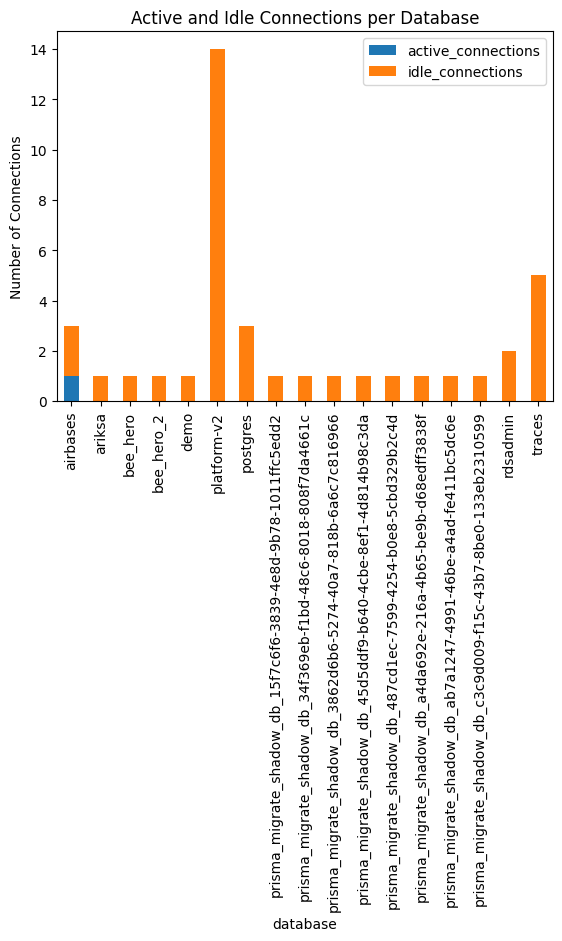

In [31]:
query_ccnnections_metrics = """
SELECT datname as database, 
       COUNT(*) FILTER (WHERE state = 'active') AS active_connections, 
       COUNT(*) FILTER (WHERE state = 'idle') AS idle_connections
FROM pg_stat_activity
WHERE datname IS NOT NULL
GROUP BY datname
ORDER BY datname
"""

df = pd.read_sql_query(query_ccnnections_metrics, connection)
df

# Plot the results as a bar chart
ax = df.plot(kind='bar', x='database', stacked=True)
ax.set_xlabel('database')
ax.set_ylabel('Number of Connections')
ax.set_title('Active and Idle Connections per Database')
plt.show()